### **5 Fold Cross Validation**
* Without validation 
* 5 classification
* Color transformation: RGB, R, G, B, RG, RB, GB, HSV, CMYK, CIElab, Gray scale, YUV

In [2]:
import torch
import cv2
import numpy as np
from random import shuffle
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [3]:
#Test GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Reading RGB images paths

In [18]:
#Path
path_base = '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/'
folders_cell = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-intermediate']
folders_mask = ['imagenes']

full_dir_rgb = []
for indice_cell in range(1,6):#cells file
    #print(indice_cell)
    for indice_mask in range(1,2):#mask file
        #print(indice_mask)
        path = path_base + folders_cell[indice_cell-1] + '/' + folders_mask[indice_mask-1] + '/'
        ele_img = os.listdir(path)
        ele_img.sort()
        #print(len(ele_img))
        #print(ele_img)

        for i in range(len(ele_img)):
            full_dir_rgb.append(path + ele_img[i])

#print(len(full_dir_rgb))


In [20]:
#Build targets for each classs
trg1 = []
trg2 = []
trg3 = []
trg4 = []
trg5 = []
target_total = []
for indice_cell in range(1,6):
  path = path_base + folders_cell[indice_cell-1] +'/imagenes/'
  ele_img = os.listdir(path)
  #print(path)
  print('Index: ',indice_cell)

  if indice_cell == 1:
    trg1 = np.zeros((1,len(ele_img)),dtype=int)#target of dyskeratotic
    print(trg1.shape)
    #print(trg1)
  elif indice_cell == 2:
    trg2 = np.ones((1,len(ele_img)),dtype=int)*1#target of koilocytotic
    print(trg2.shape)
    #print(trg2)
  elif indice_cell == 3:
    trg3 = np.ones((1,len(ele_img)),dtype=int)*2#target of metaplastic
    print(trg3.shape)
    #print(trg3)
  elif indice_cell == 4:
    trg4 = np.ones((1,len(ele_img)),dtype=int)*3#target of parabasal
    print(trg4.shape)
    #print(trg4)
  else:
    trg5 = np.ones((1,len(ele_img)),dtype=int)*4#target of superficial-intermediate
    print(trg5.shape)
    #print(trg5)


target_total = np.concatenate((trg1,trg2,trg3,trg4,trg5),axis=1)
target_total = np.transpose(target_total)
print('All targets: ',target_total.shape)
#print(target_total)

Index:  1
(1, 813)
Index:  2
(1, 807)
Index:  3
(1, 792)
Index:  4
(1, 787)
Index:  5
(1, 824)
All targets:  (4023, 1)


**Show random images**

/tmp/ipykernel_10782/494060311.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])
/tmp/ipykernel_10782/494060311.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

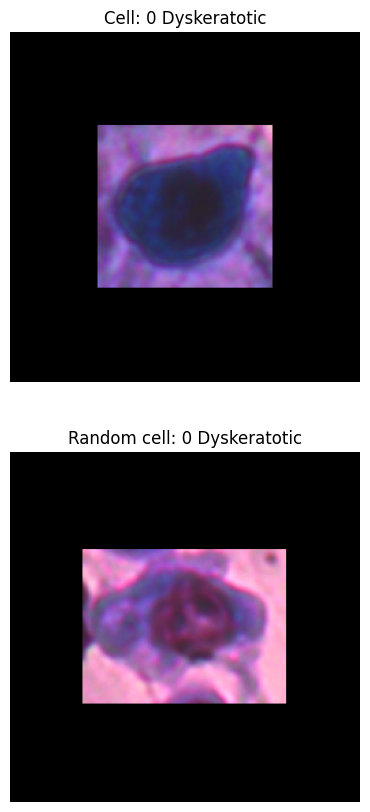

In [21]:
num_aleat1 = np.random.randint(0,high=4023-1)
num_aleat2 = np.random.randint(0,high=4023-1)

img = cv2.imread(full_dir_rgb[num_aleat1])
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(img)
aux = int(target_total[num_aleat1])
ax[0].set_title(f'Cell: {aux} {folders_cell[aux]}')
ax[0].axis('off')

img = cv2.imread(full_dir_rgb[num_aleat2])
ax[1].imshow(img)
aux = int(target_total[num_aleat1])
ax[1].set_title(f'Random cell: {aux} {folders_cell[aux]}')
ax[1].axis('off')


**Split train and test sets**

In [22]:
#Mix directories and split the dataset 80:20
shuffle_data = True  # shuffle the addresses before saving
if shuffle_data:
    d = list(zip(full_dir_rgb,target_total))#zip-> mix the two lists
    shuffle(d)#random
    full_dir_rgb, target_total = zip(*d)#zip-> separete the two lists

#Train directories
train_dir_rgb = full_dir_rgb[0:int(len(full_dir_rgb) * 0.80)]
train_target = target_total[0:int(len(target_total) * 0.80)]

#Test directories
test_dir_rgb = full_dir_rgb[(int(len(full_dir_rgb) * 0.80)):int(len(full_dir_rgb))]
test_target = target_total[(int(len(target_total) * 0.8)):int(len(target_total))]

print("V. train rgb: ",len(train_dir_rgb))
print("V. test rgb: ",len(test_dir_rgb))
print("V. total: ",len(train_dir_rgb)+len(test_dir_rgb))
print("Target train: ",len(train_target))
print("Target test: ",len(test_target))
print("Target total: ",len(train_target)+len(test_target))

#Target to tensors 
train_target = np.array(train_target)
test_target = np.array(test_target)

train_tensor = torch.tensor(train_target, dtype=torch.long)
test_tensor = torch.tensor(test_target, dtype=torch.long)

train_tensor = train_tensor.squeeze()#one dimension
test_tensor = test_tensor.squeeze()


V. train rgb:  3218
V. test rgb:  805
V. total:  4023
Target train:  3218
Target test:  805
Target total:  4023


In [23]:
print(test_tensor.shape)

torch.Size([805])


**Transformaciones**

In [24]:
#Validation and train tranformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [25]:
#Test tranformations
transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [26]:
#YUV color space transformation
def yuv_space_model(img):
    img = np.asarray(img).astype(np.float32)

    #Normalization of each channel
    img_nor = np.zeros_like(img)
    for c in range(3):
        c_min = img[:, :, c].min()
        c_max = img[:, :, c].max()
        img_nor[:, :, c] = (img[:, :, c] - c_min) / (c_max - c_min)

    img_nor_aux = Image.fromarray((img_nor * 255).astype(np.uint8))

    # Conversion RGB -> YUV
    T = np.array([
        [0.2990,  0.5870,  0.1140],
        [-0.1471, -0.2888, 0.4359],
        [0.6148, -0.5148, -0.1000]
    ])

    yuv_img = img_nor @ T.T 
    yuv_img_aux = Image.fromarray((yuv_img * 255).astype(np.uint8))

    return yuv_img, yuv_img_aux, img_nor_aux
   

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

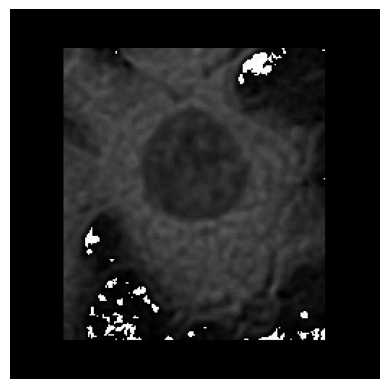

In [27]:
#Show sample in other color space

img = Image.open('/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/211_02_rsze.bmp')

yuv_img, img, img_nor_aux = yuv_space_model(img)
#img = img.convert('HSV')

img1 = transform_test(img)
img1 = np.transpose(img1,(1,2,0))
img1 = img1[:,:,2]

plt.imshow(img1,cmap='gray')
plt.axis('off')
#ax[1].imshow(img1)



torch.Size([256, 256, 3])
torch.Size([256, 256])


/tmp/ipykernel_10782/2375180387.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])
/tmp/ipykernel_10782/2375180387.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])


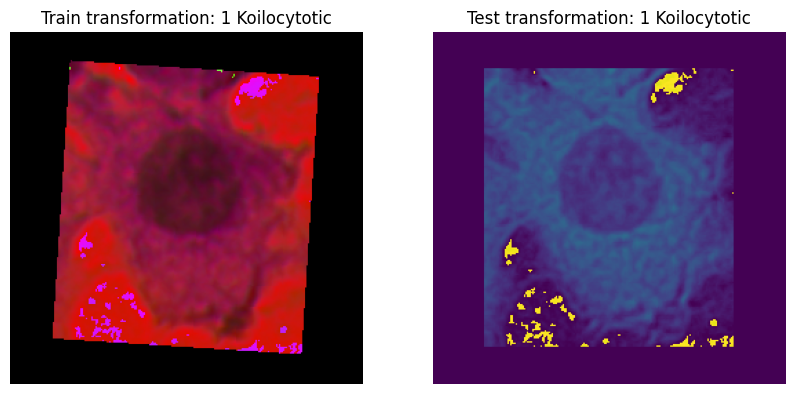

In [28]:
#Transformation and funtion checks
num_aleat1 = np.random.randint(0,high=3218-1)
num_aleat2 = np.random.randint(0,high=805-1)

#img = Image.open(train_dir_rgb[num_aleat1])
img = Image.open('/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/211_02_rsze.bmp')

yuv_img, img, img_nor_aux = yuv_space_model(img)

img1 = transform_train(img)
img1 = np.transpose(img1,(1,2,0))

fig, ax = plt.subplots(1,2,figsize=(10,10))
aux = int(target_total[num_aleat1])
ax[0].imshow(img1)
ax[0].set_title(f'Train transformation: {aux} {folders_cell[aux]}')
ax[0].axis('off')

print(img1.shape)

img1 = transform_test(img)
img1 = np.transpose(img1,(1,2,0))
img1 = img1[:,:,2]
aux = int(target_total[num_aleat1])
ax[1].imshow(img1)
ax[1].set_title(f'Test transformation: {aux} {folders_cell[aux]}')
ax[1].axis('off')

print(img1.shape)


**Dataloader for TRAIN Y TEST_VALIDATION**

In [30]:
#It is like a generator in tensorflow 
class ImageDaset(Dataset):
    def __init__(self,dir_rgb,train_tensor,transform = None):
        self.dir_rgb = dir_rgb#address
        self.train_tensor = train_tensor#targets
        self.transform = transform#transformation 

    def __len__(self):
        #Lenght of dataset
        return len(self.dir_rgb)
    
    def __getitem__(self, idx):
        #Returns an image and taget 
        rgb_path = self.dir_rgb[idx]#path 

        #Get target
        label = self.train_tensor[idx]

        #Image processing
        img = Image.open(rgb_path)

        #COLOR TRANSFORMATION
        #img1 = img#RGB
        _,img1,_ = yuv_space_model(img)#YUV
        #img1 = img.convert('LAB')#LAB, CMYK,HSV
        #h,s,v = img1.split()#split channels
        #img1 = v
        #img1 = ImageOps.grayscale(img)#grayscale
        #img1 = img.getchannel('B')#split rgb channels

        #Two channels RG, RB, GB
        #arr = np.array(img)#covert to array        
        #r = arr[:,:,0]
        #g = arr[:,:,1]
        #b = arr[:,:,2]

        #new = np.zeros((256,256,2),dtype=np.uint8)
        #new = np.stack((g,b),axis=-1)
        #img1=new
        #new[:,:,0] = g
        #new[:,:,1] = b

        #img1 = Image.fromarray(new, mode='LA')    
       
        #Applay transformations
        if self.transform:
            img = self.transform(img1)


        return img,label


In [29]:
#Reset weight function
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [31]:
#Model
class BMaskCNN(nn.Module):
    def __init__(self, num_class):
        super(BMaskCNN, self).__init__()

        self.cov1c = nn.Conv2d(3,32,kernel_size=5,stride=1,padding='valid')
        self.bch1c = nn.BatchNorm2d(32)
        self.rel1c = nn.ReLU()
        self.avg1c = nn.MaxPool2d(kernel_size=3, stride=1)

        self.cov2c = nn.Conv2d(32,64,kernel_size=3,stride=2,padding='valid')
        self.bch2c = nn.BatchNorm2d(64)
        self.rel2c = nn.ReLU()
        self.avg2c = nn.MaxPool2d(kernel_size=3, stride=1)

        self.c3 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding='valid')
        self.bch3 = nn.BatchNorm2d(128)
        self.rel3 = nn.ReLU()
        self.avg3 = nn.MaxPool2d(kernel_size=3,stride=2)

        self.c4 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding='valid')
        self.bch4 = nn.BatchNorm2d(128)
        self.rel4 = nn.ReLU()
        self.avg4 = nn.MaxPool2d(kernel_size=3,stride=1)
        
        #Fully connected 
        self.fc1 = nn.Linear(128*12*12,1000)
        self.rel1 = nn.ReLU()
        self.dr1 = nn.Dropout(0.5)

        #self.fc2 = nn.Linear(2000,510)
        #self.rel2 = nn.ReLU()
        #self.dr2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(1000,128)
        self.rel33 = nn.ReLU()

        self.fcout = nn.Linear(128,num_class)

    def forward(self, x1):
        x1 = self.avg1c(self.rel1c(self.bch1c(self.cov1c(x1))))
        x1 = self.avg2c(self.rel2c(self.bch2c(self.cov2c(x1))))

        x3 = self.avg3(self.rel3(self.bch3(self.c3(x1))))
        x4 = self.avg4(self.rel4(self.bch4(self.c4(x3))))

        #Flatten
        x = torch.flatten(x4, start_dim=1)
        
        #*Fully connected layers
        x5 = self.rel1(self.fc1(x))
        #x6 = self.dr2(self.rel2(self.fc2(x5)))
        x7 =self.rel33(self.fc3(x5))
        outputs = self.fcout(x7)    

        return outputs

        

In [32]:
#Create a model instance
model = BMaskCNN(num_class=5)
model = model.to(device)

In [33]:
input1_size = (3,256,256)
summary(model, input_size=[input1_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 252, 252]           2,432
       BatchNorm2d-2         [-1, 32, 252, 252]              64
              ReLU-3         [-1, 32, 252, 252]               0
         MaxPool2d-4         [-1, 32, 250, 250]               0
            Conv2d-5         [-1, 64, 124, 124]          18,496
       BatchNorm2d-6         [-1, 64, 124, 124]             128
              ReLU-7         [-1, 64, 124, 124]               0
         MaxPool2d-8         [-1, 64, 122, 122]               0
            Conv2d-9          [-1, 128, 59, 59]         204,928
      BatchNorm2d-10          [-1, 128, 59, 59]             256
             ReLU-11          [-1, 128, 59, 59]               0
        MaxPool2d-12          [-1, 128, 29, 29]               0
           Conv2d-13          [-1, 128, 14, 14]         147,584
      BatchNorm2d-14          [-1, 128,

In [34]:
#General configurations
k_folds = 5#k-folds
num_epochs = 200
batch = 32
criterion = torch.nn.CrossEntropyLoss()  # Loss function
results_train = {}
results_test = {}
torch.manual_seed(42)


In [35]:
#Join paths
dataset = train_dir_rgb + test_dir_rgb
targets = torch.cat((train_tensor,test_tensor),0)

print('Size dataset: ', len(dataset))
print('Size targets: ', targets.shape)

Size dataset:  4023
Size targets:  torch.Size([4023])


**Validacion cruzada**

In [ ]:
#5-fold cross validation 
kfold = KFold(n_splits=k_folds, shuffle=False)
loss_total = []
acc_total = []
predictions_total = []
labels_total = []
dataset_total = list(range(len(dataset)))
for fold,(train_ids, test_ids) in enumerate(kfold.split(dataset_total)):
    print(f'Fold {fold}')
    print('------------------------')

    #Build datasets with different transformations
    train_dataset = ImageDaset(dataset, targets, transform=transform_train)
    test_dataset = ImageDaset(dataset, targets, transform=transform_test)

    #Build subsets
    train_subset = Subset(train_dataset, train_ids)
    test_subset = Subset(test_dataset, test_ids)

    #DataLoaders
    train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    test_dataloader = DataLoader(test_subset, batch_size=batch, shuffle=False)

    model.apply(reset_weights)
    optimizer = torch.optim.Adam(model.parameters())# lr=1e-3)#optimizer

    loss_train = []
    acc_train = []
    
    #Train loop
    for epoch in range(num_epochs):
        #Train mode
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for batch_idx, (images1, labels) in enumerate(train_dataloader):
            #Move data
            images1,labels = images1.to(device), labels.to(device)
           
            outputs = model(images1)

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            #Calculate correct predictions
            _, predicted = torch.max(outputs, 1)  # Index
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        #Accuracy for each epoch
        epoch_loss = running_loss / len(train_dataloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        loss_train.append(epoch_loss)
        acc_train.append(accuracy)
        results_train[fold] = accuracy

    loss_total.append(loss_train)
    acc_total.append(acc_train)

    print(f'Train {fold} finish. Save model')
    model_name_fold = f'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Modelos_y_Dataloder/cross_{fold}_5class_YUV.pth'
    
    torch.save(model.state_dict(), model_name_fold) 

    #Train finish, start test
    correct = 0
    total = 0
  
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images1, labels in test_dataloader:
            images1, labels = images1.to(device), labels.to(device)

            outputs = model(images1)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #Accuracy
    #average_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    

    print(f"Test Accuracy: {accuracy:.2f}%")
    print('----------------------------')
    results_test[fold] = accuracy
    #Calculate and save confusion matrix
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predictions_total.append(all_predictions)
    labels_total.append(all_labels)
    #cm = metrics.confusion_matrix(all_labels, all_predictions)
    #cm_total[fold]
    

#Show all acc for each folds
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results_test.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results_test.items())} %')

    

        


Fold 0
------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=18432, out_features=100

In [ ]:
#Save dataloader
torch.save(test_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/Modelos_y_Dataloder/dataloader_test_5class_yuv.pth')
torch.save(train_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/Modelos_y_Dataloder/dataloader_ train_5class_yuv.pth')


In [ ]:
#Average acc TRAIN
f1 = acc_total[0]
f2 = acc_total[1]
f3 = acc_total[2]
f4 = acc_total[3]
f5 = acc_total[4]
prom_acc_train = (f1[-1]+f2[-1]+f3[-1]+f4[-1]+f5[-1])/5
print('Average acc de trian: ',prom_acc_train)

Promedio acc de trian:  99.3723388419173


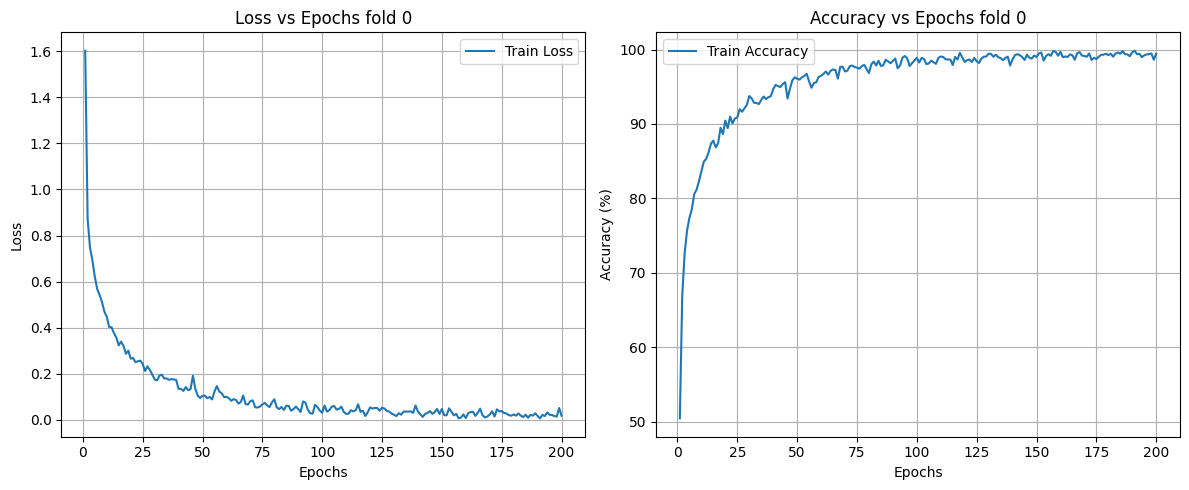

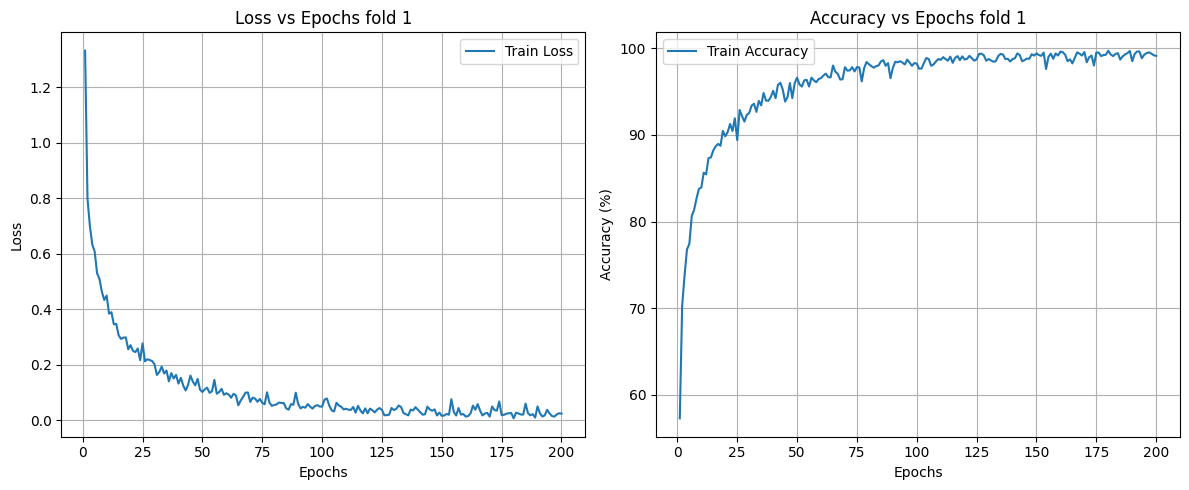

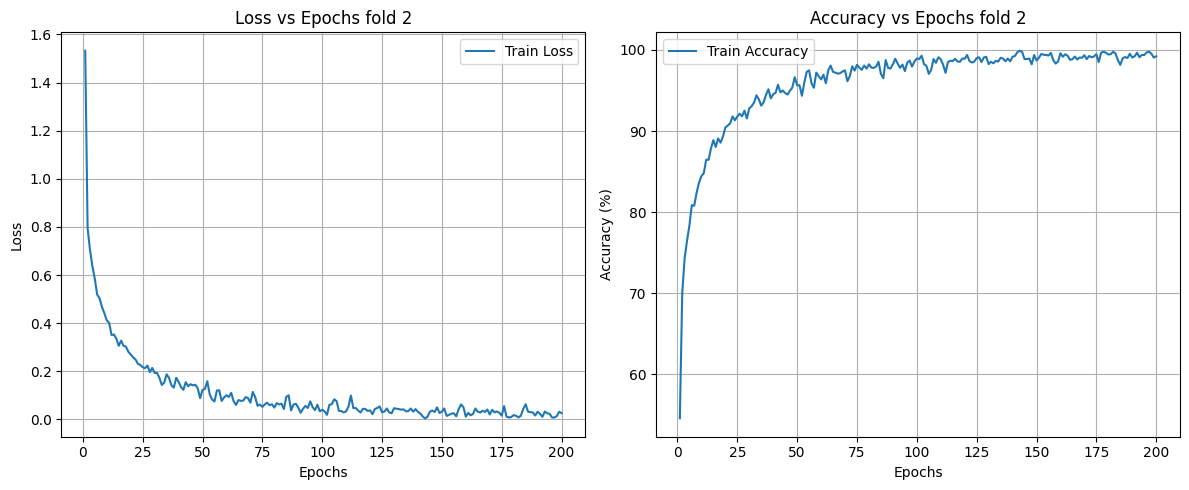

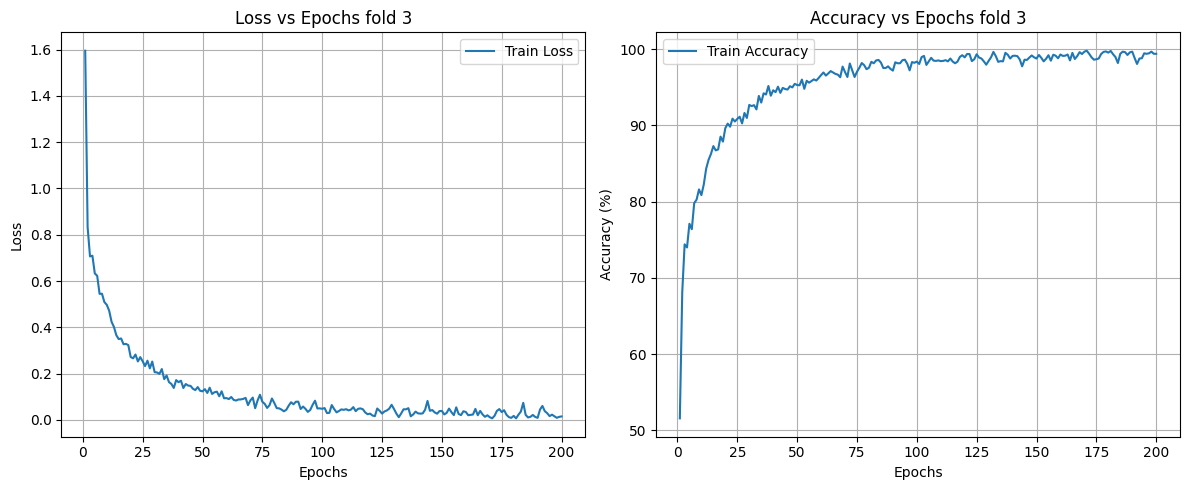

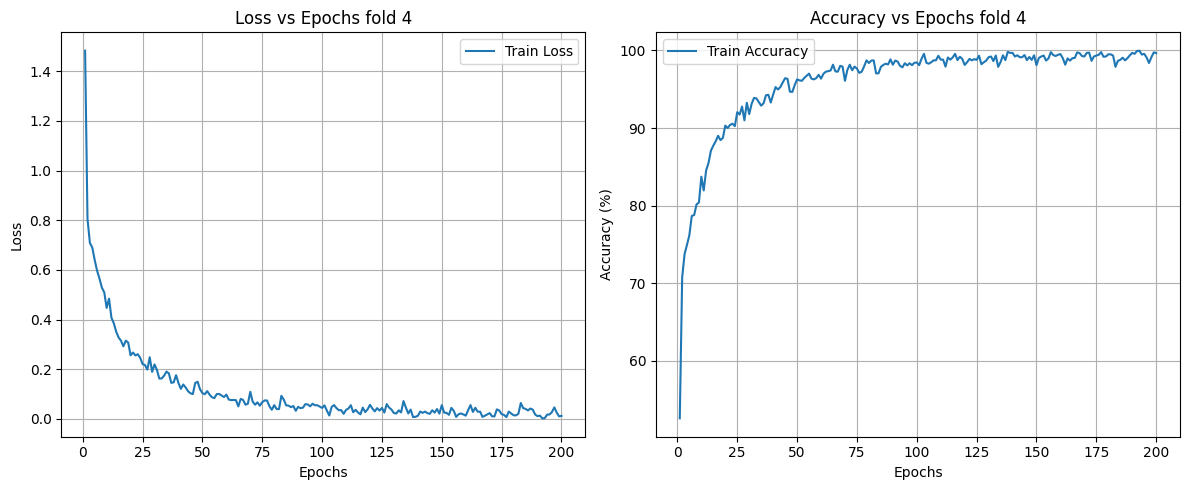

In [ ]:
#Show loss y acc graphs for each folds

for fold in range(len(loss_total)):
    plt.figure(figsize=(12, 5))
    
    #Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss_total[fold], label="Train Loss")
    #plt.plot(range(1, num_epochs + 1), loss_val, label="Validation Loss", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)

    #Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), acc_total[fold], label="Train Accuracy")
    #plt.plot(range(1, num_epochs + 1), acc_val, label="Validation Accuracy", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Loss/loss_acc_yuv{fold}.jpg", bbox_inches='tight')


    plt.tight_layout()
    plt.show()


### Confusion matrixes TEST

**Confusion matrixes with decimals**

MATRIZ DE CONFUSION DE CADA FOLD


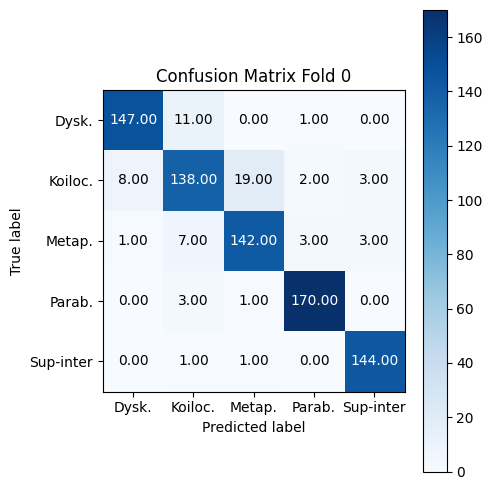

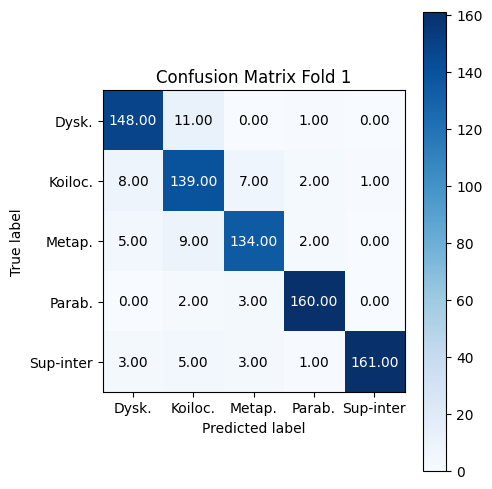

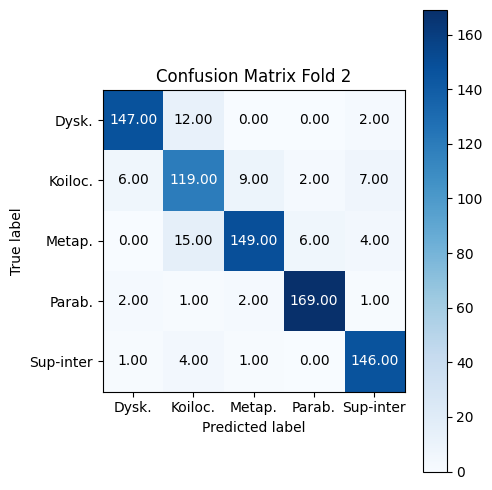

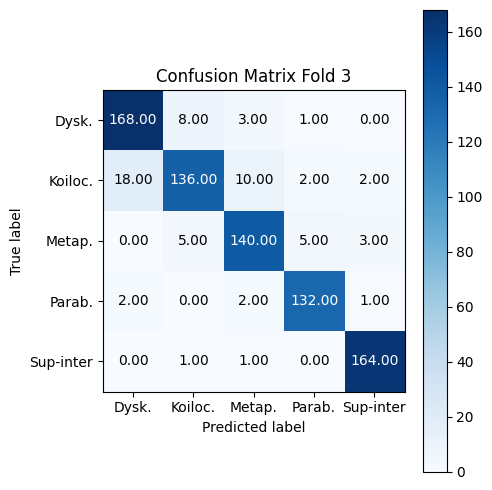

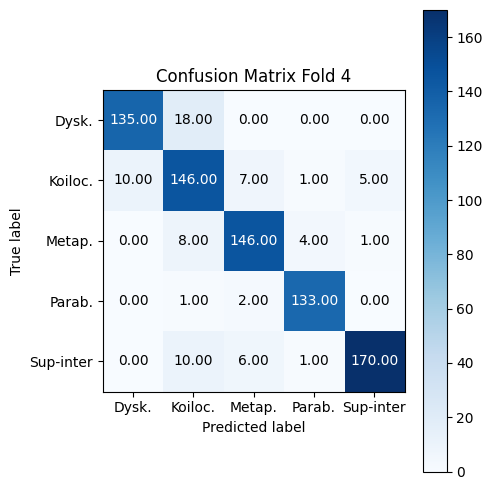

In [ ]:
#vamos a visualizar todas las matrices de confusion para cada fold 
#print("MATRIZ DE CONFUSION DE CADA FOLD")
target_names = ['Dysk.','Koiloc.','Metap.','Parab.','Sup-inter']
cm_normalized_total_ORG = np.zeros((5,5))
for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])
    #print(cm)
    #cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'Confusion Matrix Fold {fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_yuv{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()


**Average confusion matrixes with decimals**

MATRIZ DE CONFUSION PROMEDIO
[[149.   12.    0.6   0.6   0.4]
 [ 10.  135.6  10.4   1.8   3.6]
 [  1.2   8.8 142.2   4.    2.2]
 [  0.8   1.4   2.  152.8   0.4]
 [  0.8   4.2   2.4   0.4 157. ]]


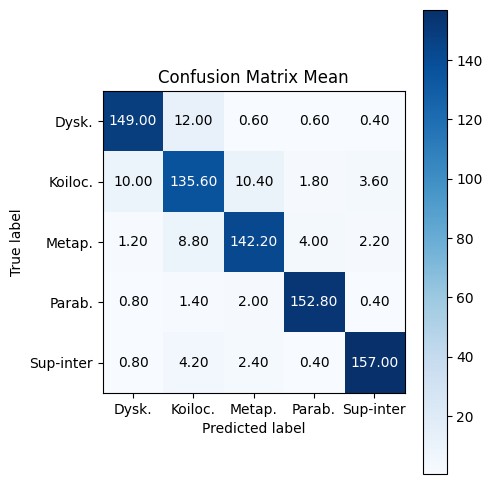

In [73]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_decimales_yuv.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()



**Confusion matrixes without decimals**

MATRIZ DE CONFUSION PROMEDIO
[[149.  12.   1.   1.   0.]
 [ 10. 136.  10.   2.   4.]
 [  1.   9. 142.   4.   2.]
 [  1.   1.   2. 153.   0.]
 [  1.   4.   2.   0. 157.]]


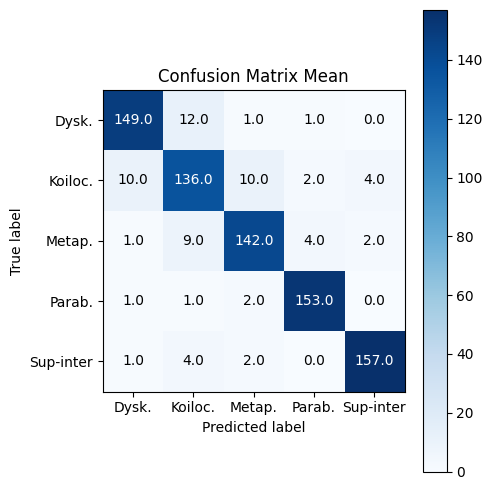

In [74]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = np.round(cm_normalized_total_ORG/5)
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j]),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_sin_decimales_yuv.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()


MATRIZ DE CONFUSION DE CADA FOLD


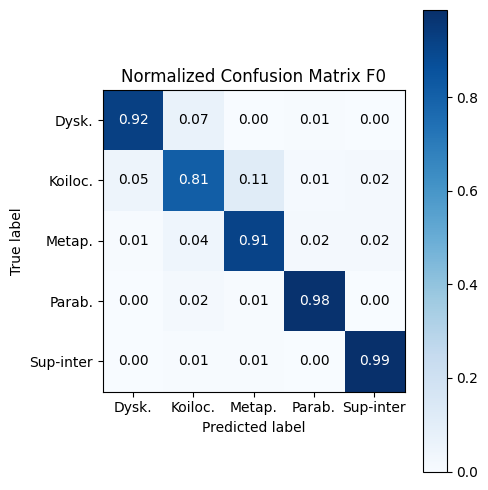

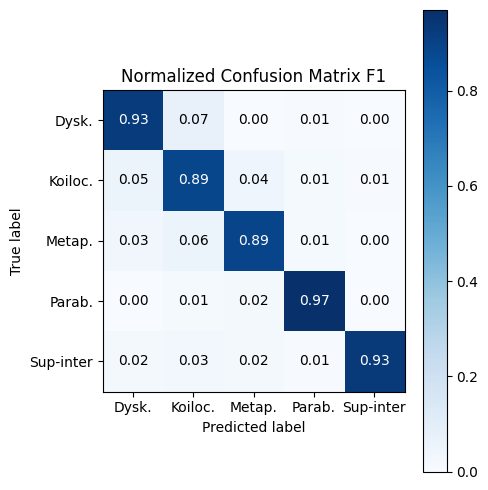

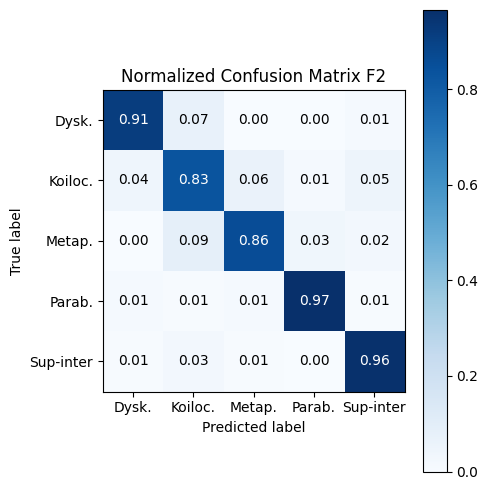

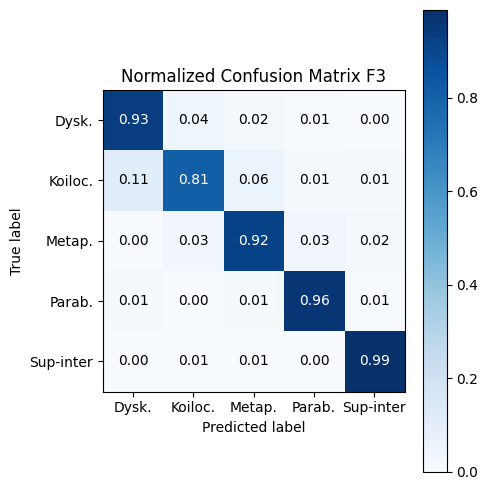

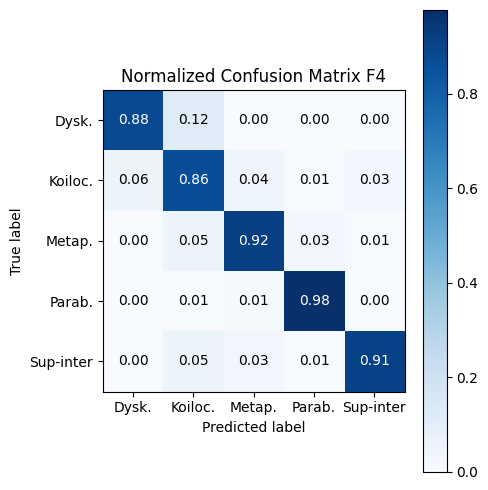

In [75]:
#vamos a visualizar todas las matrices de confusion para cada fold 
print("MATRIZ DE CONFUSION DE CADA FOLD")
target_names = ['Dysk.','Koiloc.','Metap.','Parab.','Sup-inter']
cm_normalized_total_ORG = np.zeros((5,5))
for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])
    #print(cm)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'Normalized Confusion Matrix F{fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_yuv_Nor{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()


MATRIZ DE CONFUSION PROMEDIO
[[0.91565161 0.07491161 0.00333333 0.00361897 0.00248447]
 [0.06125735 0.8405424  0.06404634 0.0112623  0.02289162]
 [0.00794872 0.05481458 0.89863665 0.02497677 0.01362329]
 [0.00520542 0.00848596 0.01293239 0.97077352 0.00260271]
 [0.004784   0.02431337 0.01377579 0.00222559 0.95490125]]


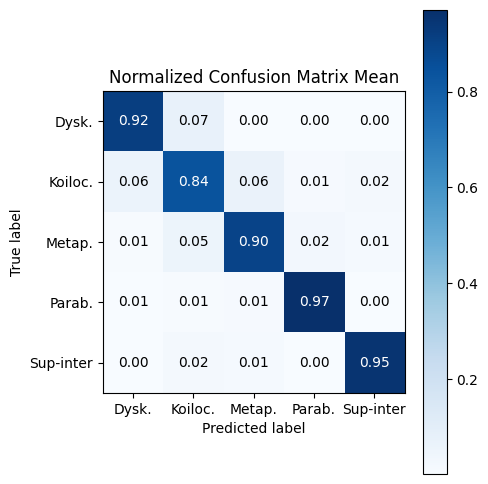

In [76]:
#matriz de confusion promedio 
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Normalized Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_yuv_Nor.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()

In [36]:
#Metrics
print("METRICAS DE CADA FOLD")
precision_total = np.zeros((1,5))
recalll_total = np.zeros((1,5))
f1_total = np.zeros((1,5))
accuracy_total = 0
for fold in range(len(predictions_total)):
    precision_total = precision_score(labels_total[fold],predictions_total[fold],average=None) + precision_total
    recalll_total = recall_score(labels_total[fold],predictions_total[fold],average=None) + recalll_total
    f1_total = f1_score(labels_total[fold],predictions_total[fold],average=None) + f1_total
    accuracy_total = accuracy_score(labels_total[fold],predictions_total[fold]) + accuracy_total

    report = classification_report(labels_total[fold],predictions_total[fold], target_names=target_names)
    print(report)
    
    with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Reportes_cross_validation/reportes_crossval_yuv.txt", "a") as f:
        f.write(f"===== Fold {fold} =====\n")
        f.write(report)
        f.write("\n\n")  # espacio entre folds

METRICAS DE CADA FOLD


NameError: name 'predictions_total' is not defined

In [ ]:
#Average metrics
print("METRICAS PROMEDIO")
print("Precision: ",precision_total/5)
print("Recall: ",recalll_total/5)
print("F1-score: ",f1_total/5)
print("Accuracy: ",accuracy_total/5)

with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Reportes_cross_validation/reportes_crossval_yuv.txt", "a") as f:
    f.write(f"===== Average =====\n")
    f.write(f'Precision: {precision_total/5}\n')
    f.write(f'Recall: {recalll_total/5}\n')
    f.write(f'F1-score: {f1_total/5}\n')
    f.write(f'Accuracy: {accuracy_total/5}\n')
    f.write("\n\n")

METRICAS PROMEDIO
Precision:  [[0.92234118 0.83848195 0.90249286 0.95685169 0.95938843]]
Recall:  [[0.91565161 0.8405424  0.89863665 0.97077352 0.95490125]]
F1-score:  [[0.91868842 0.83829199 0.90016803 0.96375291 0.95657881]]
Accuracy:  0.915485306387318
